# L'Oréal Hackathon - Simple Topic Modeling

This notebook performs **topic modeling** on quality comments from your YouTube dataset using scikit-learn's LDA (Latent Dirichlet Allocation).

## What this notebook does:
1. **Loads quality comments** from `complete_comments_top20_features.csv` (filtered from spam detection)
2. **Preprocesses text** using NLTK (stopwords, lemmatization, cleaning)
3. **Creates TF-IDF features** for numerical representation
4. **Discovers 5 topics** using LDA topic modeling
5. **Visualizes topics** with word clouds
6. **Assigns topics** to comments and videos
7. **Exports results** as CSV files

## Outputs:
- `comment_topics_simple.csv` - Each comment with its dominant topic
- `video_topics_simple.csv` - Each video with its dominant topic
- Word cloud visualizations for each topic

In [2]:
# Cell 1: Setup and Data Preprocessing

import pandas as pd
import re
!pip install nltk 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK data (only needs to be run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the processed dataset with spam classification
df = pd.read_csv('complete_comments_top20_features.csv')

# Filter for quality comments only (remove spam)
print(f"Total comments loaded: {len(df):,}")

# Check available spam classification columns
spam_col = None
if 'spam_classification' in df.columns:
    spam_col = 'spam_classification'
elif 'final_labels' in df.columns:
    spam_col = 'final_labels'

if spam_col:
    print(f"Found spam classification column: '{spam_col}'")
    unique_values = df[spam_col].value_counts()
    print(f"Classification distribution: {dict(unique_values)}")
    
    # Filter for quality comments only
    df = df[df[spam_col] == 'quality'].copy()
    print(f"Using {len(df):,} quality comments for topic modeling")
else:
    print("⚠️  No spam classification found. Using all comments.")

# Reset index after filtering
df = df.reset_index(drop=True)

# --- Text Preprocessing ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove emojis and other non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove stop words and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(lemmatized_tokens)

# Apply the preprocessing function to the 'textOriginal' column
df['cleaned_text'] = df['textOriginal'].astype(str).apply(preprocess_text)

print("--- Sample of Cleaned Text ---")
print(df[['textOriginal', 'cleaned_text']].head())

You should consider upgrading via the 'C:\Users\user\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Total comments loaded: 3,326,124
Found spam classification column: 'spam_classification'
Classification distribution: {'quality': np.int64(3088643), 'spam': np.int64(235413), 'uncertain': np.int64(2068)}
Using 3,088,643 quality comments for topic modeling
--- Sample of Cleaned Text ---
                                        textOriginal  \
0  PLEASE LESBIAN FLAG I BEG YOU \n\nYou would ro...   
1   Apply mashed potato juice and mixed it with curd   
2                         69 missed calls from mars👽   
3                                               Baaa   
4    you look like raven from phenomena raven no cap   

                           cleaned_text  
0    please lesbian flag beg would rock  
1  apply mashed potato juice mixed curd  
2                       missed call mar  
3                                  baaa  
4  look like raven phenomenon raven cap  


In [3]:
# Cell 2: Feature Engineering (TF-IDF Vectorization)
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
# max_df=0.95 ignores terms that appear in more than 95% of the documents (corpus-specific stop words)
# min_df=2 ignores terms that appear in less than 2 documents
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the cleaned text to create the document-term matrix
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Get the feature names (the words in our vocabulary)
feature_names = vectorizer.get_feature_names_out()

print(f"--- TF-IDF Matrix Shape ---")
print(f"The matrix has {tfidf_matrix.shape[0]} rows (documents) and {tfidf_matrix.shape[1]} columns (unique words).")
print("\n--- Sample Feature Names ---")
print(list(feature_names[:10]))

--- TF-IDF Matrix Shape ---
The matrix has 3088643 rows (documents) and 141582 columns (unique words).

--- Sample Feature Names ---
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa']


In [4]:
# Cell 3: Topic Modeling with LDA
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics to find
num_topics = 5

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f"--- LDA Model Trained ---")
print(f"Successfully identified {num_topics} topics from the dataset.")

--- LDA Model Trained ---
Successfully identified 5 topics from the dataset.


In [5]:
# Cell 4: Reviewing the Topics
def display_topics(model, feature_names, no_top_words):
    print("=== DISCOVERED TOPICS ===")
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx+1}:")
        # Get top words with their weights
        top_words_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
        
        # Display words with weights
        word_list = [f"{word}({weight:.3f})" for word, weight in top_words]
        print(f"  Keywords: {', '.join(word_list)}")

# Define the number of top words to display for each topic
no_top_words = 10

print("--- Analyzing Topics from Quality Comments ---")
display_topics(lda, feature_names, no_top_words)

--- Analyzing Topics from Quality Comments ---
=== DISCOVERED TOPICS ===

Topic 1:
  Keywords: hair(25876.877), gorgeous(20785.149), amazing(15821.837), look(14472.756), girl(13972.969), skin(12688.370), like(11030.078), eye(10777.249), thanks(10692.050), happy(8810.401)

Topic 2:
  Keywords: nice(28323.550), india(26576.179), like(18767.922), pakistan(10807.428), look(9998.465), love(8623.452), super(7718.350), makeup(7409.576), video(7244.093), share(7213.244)

Topic 3:
  Keywords: beautiful(87323.693), pretty(37128.990), love(36360.232), wow(24577.964), thank(20320.324), look(20318.693), makeup(16058.879), best(11675.950), omg(10746.995), muslim(10451.394)

Topic 4:
  Keywords: cute(30637.723), good(17941.764), like(15149.942), dont(13474.958), look(13108.749), yes(12502.093), makeup(10222.219), girl(9632.765), boy(8958.129), know(8000.702)

Topic 5:
  Keywords: indian(18956.578), night(17960.211), hai(13251.850), makeup(7159.886), look(6430.750), didi(6335.909), day(6198.841), aap(

=== TOPIC ANALYSIS ===


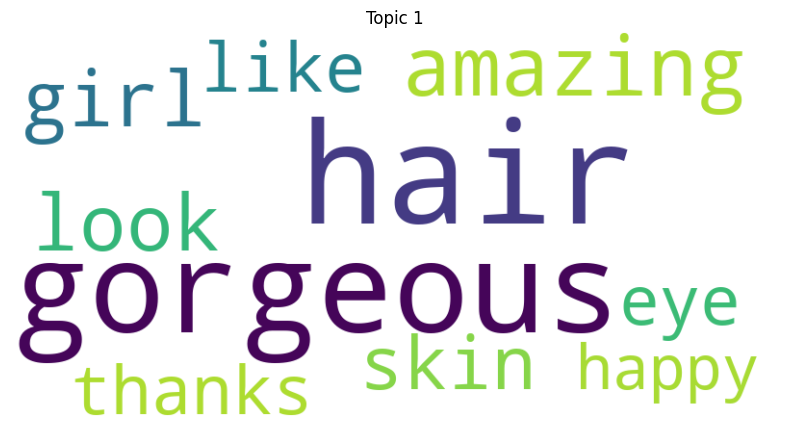

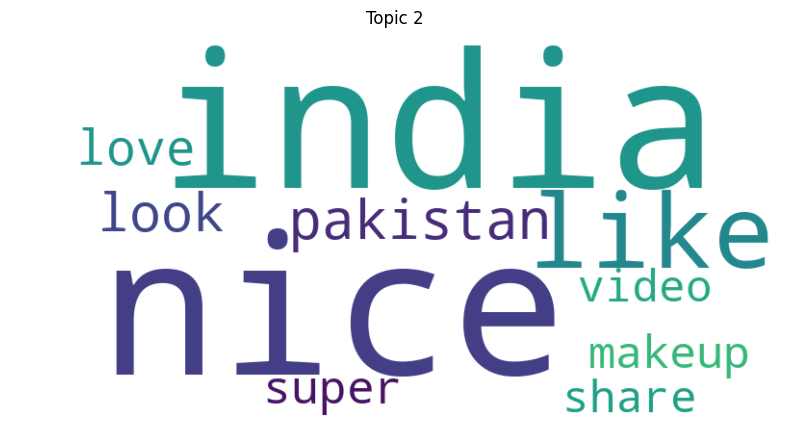

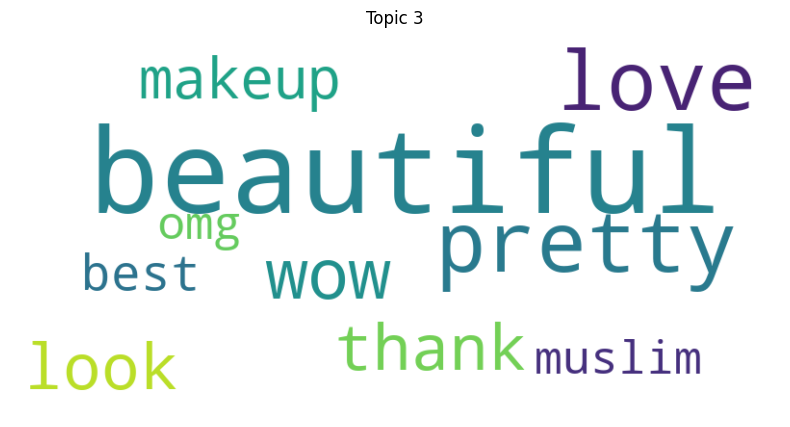

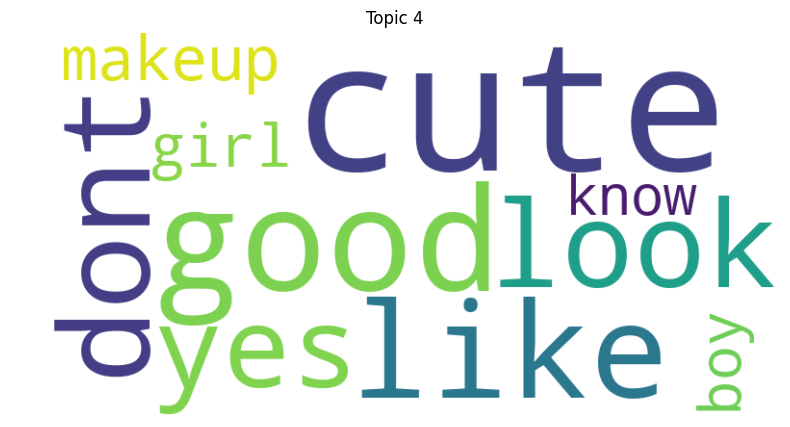

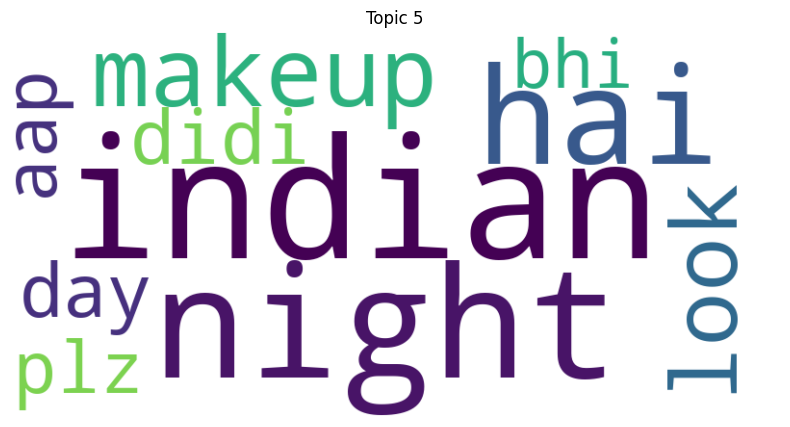


=== TOPIC DISTRIBUTION ===
Topic 1: 1,182,289 comments (38.3%)
Topic 2: 384,026 comments (12.4%)
Topic 3: 459,190 comments (14.9%)
Topic 4: 635,727 comments (20.6%)
Topic 5: 427,411 comments (13.8%)

=== VIDEO-LEVEL TOPIC ANALYSIS ===
Analyzed 35032 videos
Sample video topic assignments:
         dominant_topic  topic_probability  num_comments
videoId                                                 
0                     0           0.528049           350
2                     1           0.596169             1
6                     0           0.653634             5
8                     4           0.592739            10
11                    0           0.577030           264
15                    0           0.200000             1
19                    0           0.200000             1
22                    0           0.552437             2
25                    2           0.455562             3
26                    0           0.573316            10

✅ Exported video topic as

In [6]:
# Cell 5: Comprehensive Analysis and Export Results
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Generate word clouds for each topic
print("=== TOPIC ANALYSIS ===")
for topic_idx, topic in enumerate(lda.components_):
    # Create a dictionary of word frequencies for the current topic
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}

    # Create the word cloud object
    wc = WordCloud(background_color="white", max_words=100, width=800, height=400)
    wc.generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx+1}")
    plt.show()

# Get topic assignments for each comment
topic_assignments = lda.transform(tfidf_matrix)
df['dominant_topic'] = np.argmax(topic_assignments, axis=1)
df['topic_probability'] = np.max(topic_assignments, axis=1)

# Show topic distribution
print("\n=== TOPIC DISTRIBUTION ===")
topic_counts = df['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_counts.items():
    percentage = count / len(df) * 100
    print(f"Topic {topic_id+1}: {count:,} comments ({percentage:.1f}%)")

# Video-level analysis if videoId is available
if 'videoId' in df.columns:
    print("\n=== VIDEO-LEVEL TOPIC ANALYSIS ===")
    video_topics = df.groupby('videoId').agg({
        'dominant_topic': lambda x: x.mode().iloc[0] if not x.empty else -1,  # Most common topic
        'topic_probability': 'mean',  # Average confidence
        'textOriginal': 'count'  # Number of comments
    }).rename(columns={'textOriginal': 'num_comments'})
    
    print(f"Analyzed {len(video_topics)} videos")
    print("Sample video topic assignments:")
    print(video_topics.head(10))
    
    # Export video-level results
    video_topics['dominant_topic'] = video_topics['dominant_topic'] + 1  # Make 1-indexed for readability
    video_topics.to_csv('video_topics_simple.csv', index=True)
    print("\n✅ Exported video topic assignments: video_topics_simple.csv")

# Export comment-level results
comment_results = df[['commentId', 'videoId', 'textOriginal', 'cleaned_text', 
                     'dominant_topic', 'topic_probability']].copy()
comment_results['dominant_topic'] = comment_results['dominant_topic'] + 1  # Make 1-indexed
comment_results.to_csv('comment_topics_simple.csv', index=False)
print("✅ Exported comment topic assignments: comment_topics_simple.csv")

# Model Extraction and Saving
import joblib
import pickle
import os

# Create model directory
model_dir = 'model_simple'
os.makedirs(model_dir, exist_ok=True)

# Save the trained LDA model
model_path = os.path.join(model_dir, 'lda_model_simple.pkl')
joblib.dump(lda, model_path)
print(f"✅ Saved LDA model: {model_path}")

# Save the TF-IDF vectorizer
vectorizer_path = os.path.join(model_dir, 'tfidf_vectorizer_simple.pkl')
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ Saved TF-IDF vectorizer: {vectorizer_path}")

# Save model metadata and summary
model_metadata = {
    'num_topics': num_topics,
    'total_comments': len(df),
    'vocabulary_size': len(feature_names),
    'avg_topic_confidence': df['topic_probability'].mean(),
    'topic_distribution': dict(topic_counts),
    'feature_names': feature_names.tolist(),
    'preprocessing_params': {
        'max_df': 0.95,
        'min_df': 2,
        'stop_words': 'english'
    }
}

metadata_path = os.path.join(model_dir, 'model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"✅ Saved model metadata: {metadata_path}")

# Save topic keywords for reference
topic_keywords = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-no_top_words - 1:-1]
    top_words = [(feature_names[i], float(topic[i])) for i in top_words_idx]
    topic_keywords[f'topic_{topic_idx+1}'] = top_words

keywords_path = os.path.join(model_dir, 'topic_keywords.pkl')
with open(keywords_path, 'wb') as f:
    pickle.dump(topic_keywords, f)
print(f"✅ Saved topic keywords: {keywords_path}")

print(f"\n🎉 Simple topic modeling completed!")
print(f"   📁 Found {num_topics} topics from {len(df):,} quality comments")
print(f"   📁 Average topic confidence: {df['topic_probability'].mean():.3f}")
print(f"   📁 Model files saved in: {model_dir}/")
print(f"\n📦 Model Package Contents:")
print(f"   - lda_model_simple.pkl (trained LDA model)")
print(f"   - tfidf_vectorizer_simple.pkl (fitted TF-IDF vectorizer)")
print(f"   - model_metadata.pkl (model parameters and statistics)")
print(f"   - topic_keywords.pkl (topic keywords with weights)")